In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def generate_maze(size, p_blocked=0.3):
    maze = np.zeros((size, size), dtype=int)
    stack = []
    visited = set()
    #choose a random cell and add it to stack
    start_cell = (np.random.randint(size), np.random.randint(size))
    stack.append(start_cell)

    while stack:
        #choose latest cell in stack and get coordinates; mark it as visited
        current_cell = stack[-1]
        x, y = current_cell
        visited.add(current_cell)

        #get the neighbors and find which are unvistited; save the unvisted in an array
        neighbors = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)]
        unvisited_neighbors = [neighbor for neighbor in neighbors if 0 <= neighbor[0] < size and 0 <= neighbor[1] < size and neighbor not in visited]
        if unvisited_neighbors:
            #choose a random neighbor from unvistited neighbors array,label it as the next cell
            Neighbor_size = len(unvisited_neighbors)
            cellIndex = np.random.randint(0,Neighbor_size)
            cellIndex = cellIndex-1
            next_cell = unvisited_neighbors[cellIndex]
            nx, ny = next_cell

            #with a probability of the cell being blocked being 0.3, assign the next cell to be blocked or unblocked; add it to the stack
            if np.random.rand() < p_blocked:
                maze[nx, ny] = 1  # Blocked
            else:
                maze[nx, ny] = 0  # Unblocked

            stack.append(next_cell)
        # if there are no unvisited neighbors then dead end; pop the stack to backtrack to second latest and repeat process
        else:
            stack.pop()

    return maze
def visualize_maze(maze):
    #print("Blocked" , np.sum(maze==1))
    #print("Unblocked", np.sum(maze==0))
    plt.imshow(maze, cmap='gray', interpolation='nearest')
    plt.show()

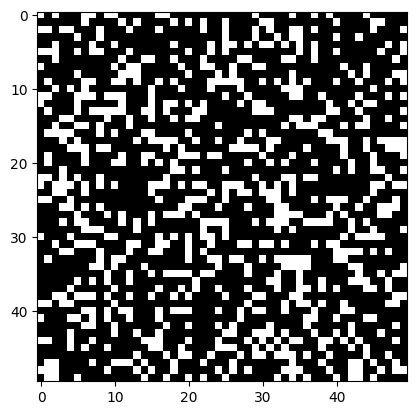

In [86]:
num_environments = 1
size = 50
mazes = []
for i in range(num_environments):
    maze = generate_maze(size)
    mazes.append(maze)
    visualize_maze(maze)

In [17]:
class Node:
    def __init__(self, state, g_cost, h_cost):
        self.state = state
        self.g_cost = g_cost
        self.h_cost = h_cost
        self.f_cost = g_cost + h_cost
        self.next = None
        self.length = 0
    def __lt__(self, other):
        return (self.f_cost) < (other.f_cost)

    def __eq__(self, other):
        return (self.f_cost) == (other.f_cost)

    def __hash__(self):
        return hash((self.state, self.g_cost, self.h_cost))

In [18]:
def getManhattan(x,y,target):
    xDiff = abs(x-target.state[0])
    yDiff = abs(y-target.state[1])
    sum = xDiff+yDiff
    return sum    

In [31]:
def coords(open):
    for node in open:
        x = node[1].state[0]
        y = node[1].state[1]
        f = node[0]
        g = node[1].g_cost
        h = node[1].h_cost
        print("Coords: (", x,",",y,") F_cost: ", f, " G_cost: ", g," H_cost: ",h)
    

In [42]:
import heapq
def getNeighbors(open,target,laze,current,paths):
    x = current.state[0]
    y = current.state[1]
    rows, cols = laze.shape
    len = current.length
    #Up
    if y>0: #checks current node is not in top row
        if(laze[x,y-1]==4): #target is above save current node to paths 
            #print("path found")
            paths.append(current)
        elif(laze[x,y-1]==0): #if cell is unblocked, not part of open list or not part of path
            laze[x,y-1]=5 #marks cell as part of open list
            Up = Node((x,y-1),current.g_cost+1,getManhattan(x,y-1,target)) #make node
            Up.next = current #point to current
            Up.length = len+1 # add to path length
            heapq.heappush(open,(Up.f_cost,Up)) #add node to open list
    #Down
    if y<rows-1: #checks current node is not in bottom row
        if(laze[x,y+1]==4): #target is below save current node to paths
            #print("path found")
            paths.append(current)
        elif(laze[x,y+1]==0):#if cell is unblocked, not part of open list or not part of path
            laze[x,y+1]=5#marks cell as part of open list
            Down = Node((x,y+1),current.g_cost+1,getManhattan(x,y+1,target))#make node
            Down.next = current #point to current 
            Down.length = len+1 # add to path length
            heapq.heappush(open,(Down.f_cost,Down))#add node to open list
    #Left
    if x>0: #checks if current node is not in first column
        if(laze[x-1,y]==4): #target is to the left save current node to paths
            #print("path found")
            paths.append(current)
        elif(laze[x-1,y]==0): #if cell is unblocked, not part of open list or not part of path
            laze[x-1,y]=5#marks cell as part of open list
            Left = Node((x-1,y),current.g_cost+1,getManhattan(x-1,y,target))#make node
            Left.next = current #point to current
            Left.length = len+1 #add to path length
            heapq.heappush(open,(Left.f_cost,Left))#add node to open list
    #Right
    if x<cols-1: #checks if current node is not in last column
        if(laze[x+1,y]==4): #target is to the right save current node to paths
            #print("path found")
            paths.append(current)
        elif(laze[x+1,y]==0):#if cell is unblocked, not part of open list or not part of path
            laze[x+1,y]=5#marks cell as part of open list
            Right = Node((x+1,y),current.g_cost+1,getManhattan(x+1,y,target))#make node
            Right.next = current #point to current
            Right.length = len+1 #add to path length
            heapq.heappush(open,(Right.f_cost,Right))#add node to open list
    #coords(open)

In [57]:
import random
def findNext(open):
    possibleNext = [] 
    # finds node(s) with minimum f_cost; adds it/them to possibleNext list
    if not open:
        return None
    fcost, minnode = heapq.heappop(open)
    possibleNext.append((fcost,minnode))
    while open and open[0][0] == fcost:
        possibleNext.append(heapq.heappop(open))
    # of the minimum f_costs nodes, finds which one(s) has the largest g_cost; if multiple then choose random
    gCostsList = []
    max = 0
    index = []
    for i in range(len(possibleNext)):
        g_cost = possibleNext[i][1].g_cost
        if g_cost > max:
            gCostsList.clear()
            gCostsList.append(possibleNext[i])
            max = g_cost
            index.clear()
            index.append(i)
        elif g_cost == max:
            gCostsList.append(possibleNext[i])
            index.append(i)
    nextIdx = random.choice(index)
    #remove next node from open; add other nodes back to open
    nextNode = possibleNext.pop(nextIdx)
    for node in possibleNext:
        heapq.heappush(open,(node[0],node[1]))
    return nextNode[1]
    

    

In [84]:
import matplotlib.pyplot as plt
def findPath(open,target,laze,current,paths):
    i = 0
    pathXY = []
    while(True):
        getNeighbors(open,target,laze,current,paths)
        #print(i)
        if(len(paths)>0):
            break
        current = findNext(open)
        if(current is None):
            return pathXY
        i = i +1 
    end = paths[0]
    
    while end is not None:
        x = end.state[0]
        y = end.state[1]
        pathXY.append((x,y))
        laze[x,y] = 2
        end = end.next
    cmap = plt.cm.colors.ListedColormap(['black', 'white', 'red','green','blue','black'])
    plt.imshow(laze, cmap=cmap, interpolation='nearest')
    plt.show()
    return pathXY


In [88]:
while(True):
    start_cell = (np.random.randint(1,size-1), np.random.randint(1,size-1))
    x,y = start_cell
    target_cell = (np.random.randint(1,size-1), np.random.randint(1,size-1))
    z,w = target_cell
    if((mazes[0][x,y] == 0) and (mazes[0][z,w]==0) and (x is not z) and (y is not w)):
        break
initialH = abs(start_cell[0]-target_cell[0])+abs(start_cell[1]-target_cell[1])
Start = Node(start_cell,0,initialH)
Target = Node(target_cell, float('inf'),0)

26 41
14 11


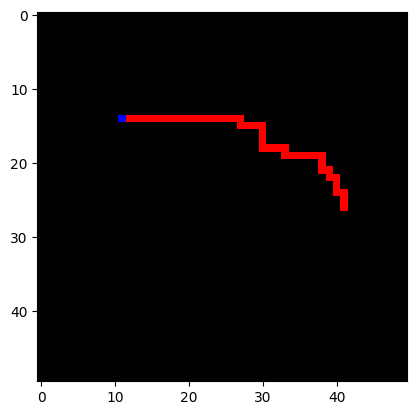

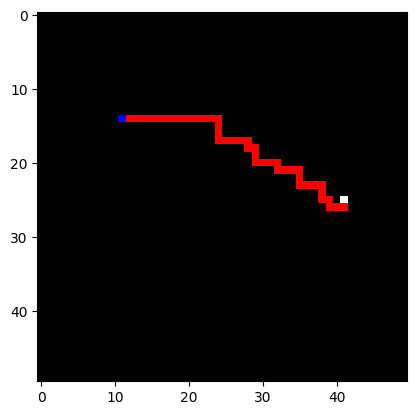

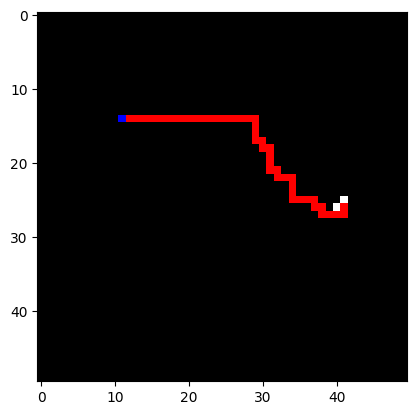

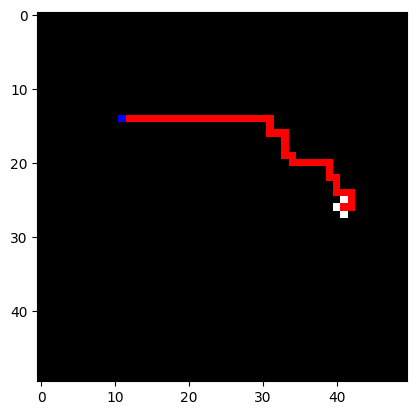

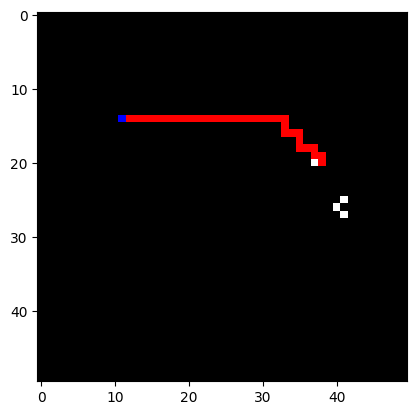

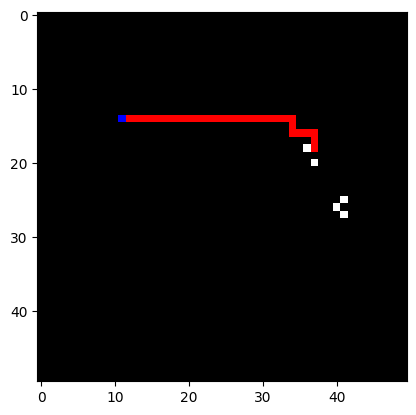

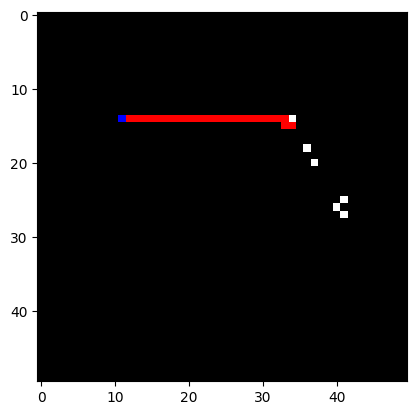

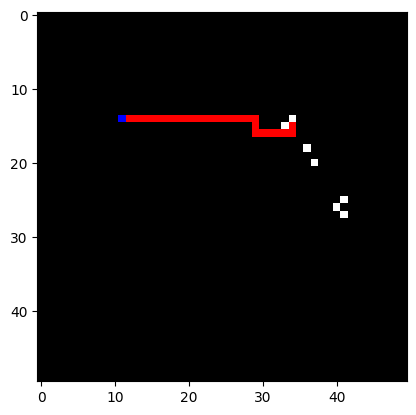

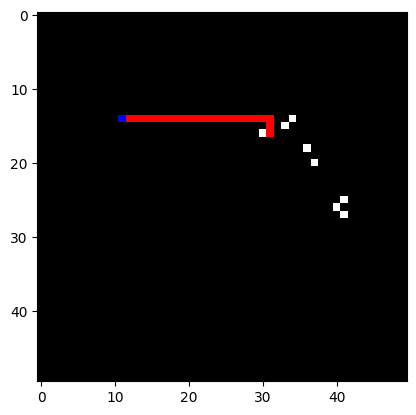

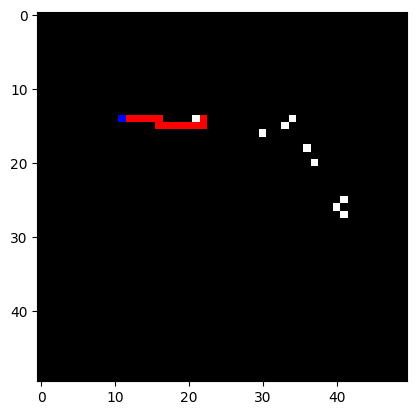

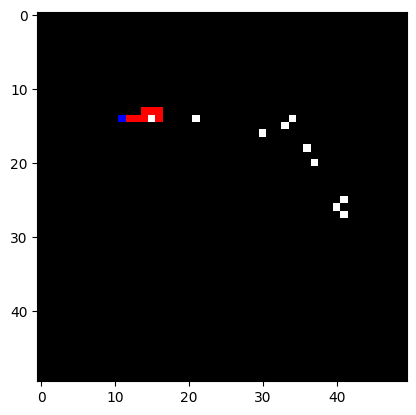

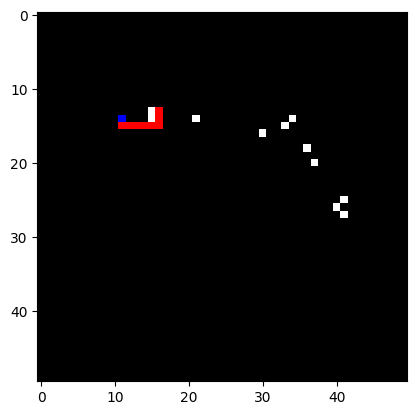

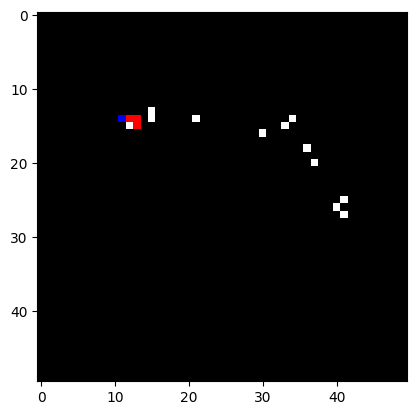

Path Found


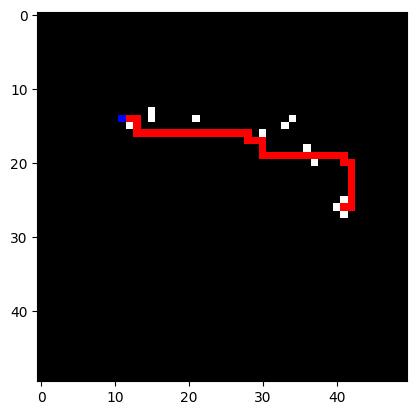

Path Length:  44


In [89]:
import heapq
open = []
paths = []
laze = np.zeros((size,size),dtype=int)
x = Start.state[0]
y = Start.state[1]
z = Target.state[0]
w = Target.state[1]
laze[x,y] = 3
laze[z,w] = 4
print(x,y)
print(z,w)
path = findPath(open,Target, laze, Start,paths)
i = -1
found = 1
while i > -(len(path)-1):
    xP = path[i][0]
    yP = path[i][1]
    xNext = path[i-1][0]
    yNext = path[i-1][1]
    if(mazes[0][xNext,yNext]==1):
        laze[xNext,yNext] =1
        laze[(laze==2)|(laze==3)|(laze==5)]=0
        laze[xP,yP] = 3
        open.clear()
        newStart = Node((xP,yP),0,getManhattan(xP,yP,Target))
        paths.clear()
        path = findPath(open,Target,laze,newStart,paths)
        if not path:
            found = 0
            break
        i = -1
    else:
        i = i -1
if found:
    print("Path Found")
    laze[(laze==2)|(laze==3)|(laze==5)]=0
    laze[x,y] = 3
    open.clear()
    paths.clear()
    path = findPath(open,Target,laze,Start,paths)
    print("Path Length: ",len(path))
    #cmap = plt.cm.colors.ListedColormap(['black', 'white', 'red','green','blue','black'])
    #plt.imshow(laze, cmap=cmap, interpolation='nearest')
    #plt.show()
else:
    print("No path")